In [3]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
import pandas as pd  

In [4]:
# Load the dataset and store it in a DataFrame called 'df'
df = pd.read_csv('../Dataset/garments_worker_productivity.csv')

# Display the first 5 rows to confirm it loaded correctly
df.head()


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [5]:
# --- THIS IS THE ONLY CODE YOU NEED FOR CATEGORICAL COLUMNS ---

# List of all categorical columns we might want to convert
categorical_cols = ['department', 'daytype', 'quarter', 'day']

# Find which of these columns actually exist in the DataFrame right now
cols_to_convert = [col for col in categorical_cols if col in df.columns]

# Convert only the columns that were actually found
if cols_to_convert:
    print(f"Fixing categorical columns: {cols_to_convert}")
    df = pd.get_dummies(df, columns=cols_to_convert, drop_first=True)
else:
    print("All categorical columns seem to be already fixed.")

# Also, drop the original 'date' column for safety, if it exists
if 'date' in df.columns:
    print("Dropping original 'date' column.")
    df = df.drop('date', axis=1)

Fixing categorical columns: ['department', 'quarter', 'day']
Dropping original 'date' column.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    691 non-null    float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  department_finishing   1197 non-null   bool   
 12  department_sweing      1197 non-null   bool   
 13  quarter_Quarter2       1197 non-null   bool   
 14  quarter_Quarter3       1197 non-null   bool   
 15  quar

In [7]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


## 3. Visualizing and Analyzing The Data (EDA)

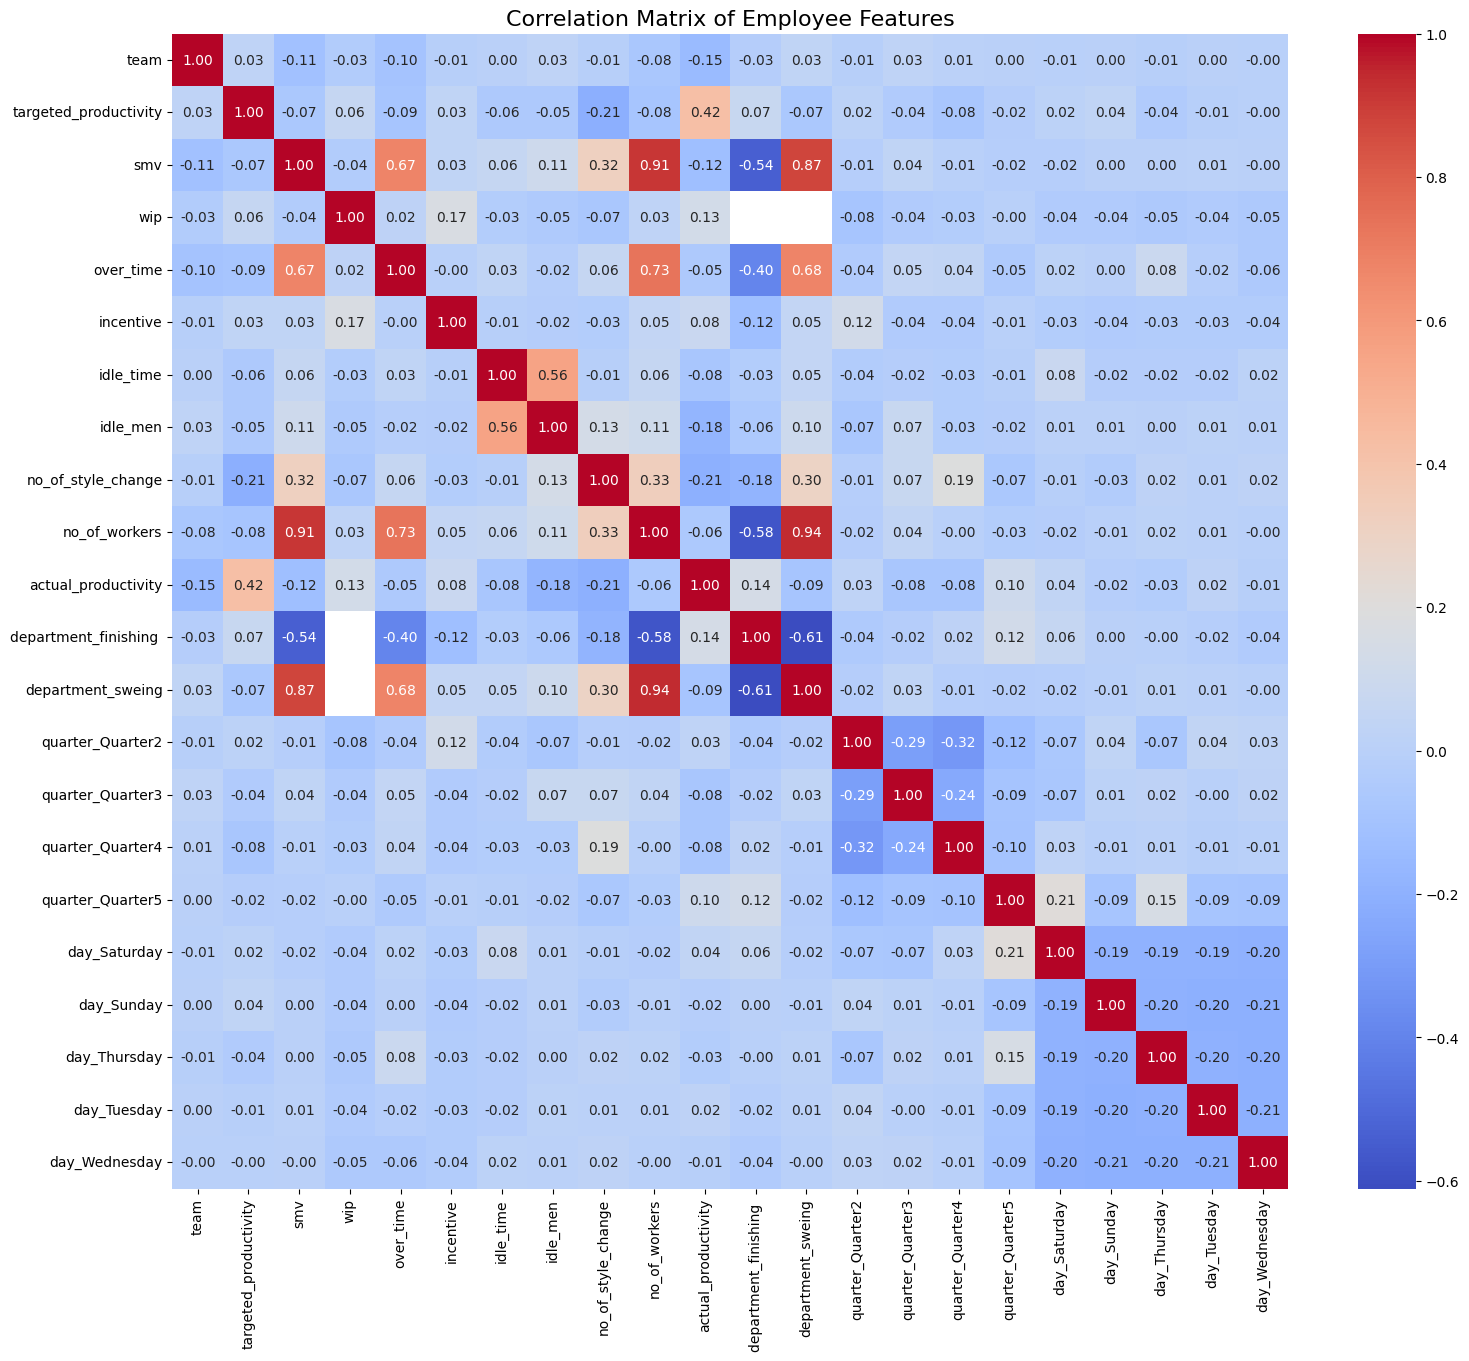

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 15))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of Employee Features', fontsize=16)
plt.show()

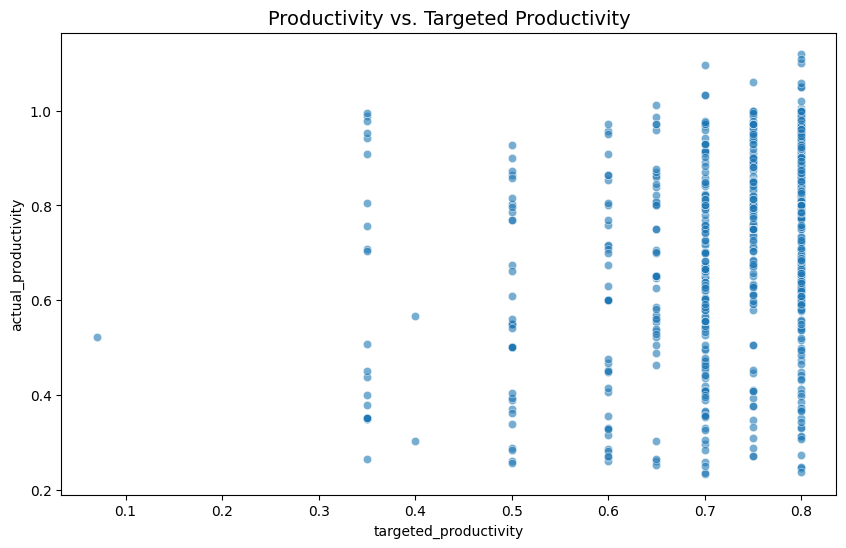

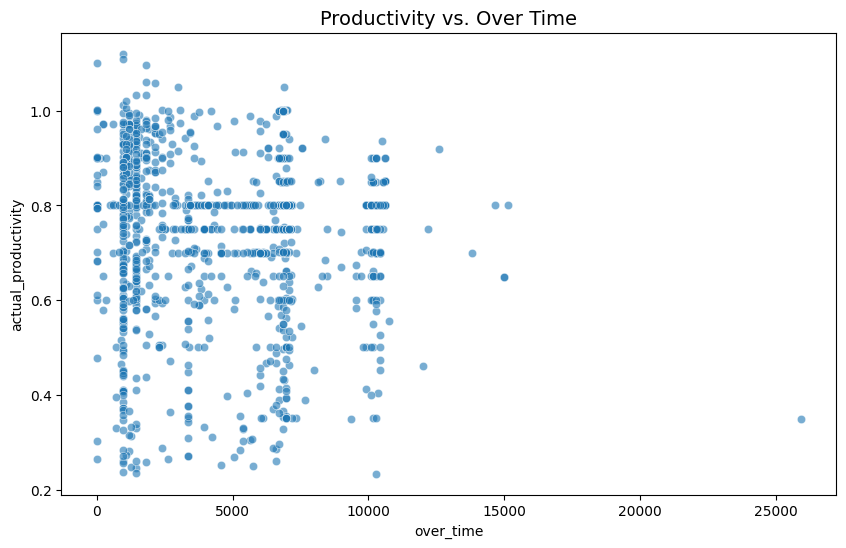

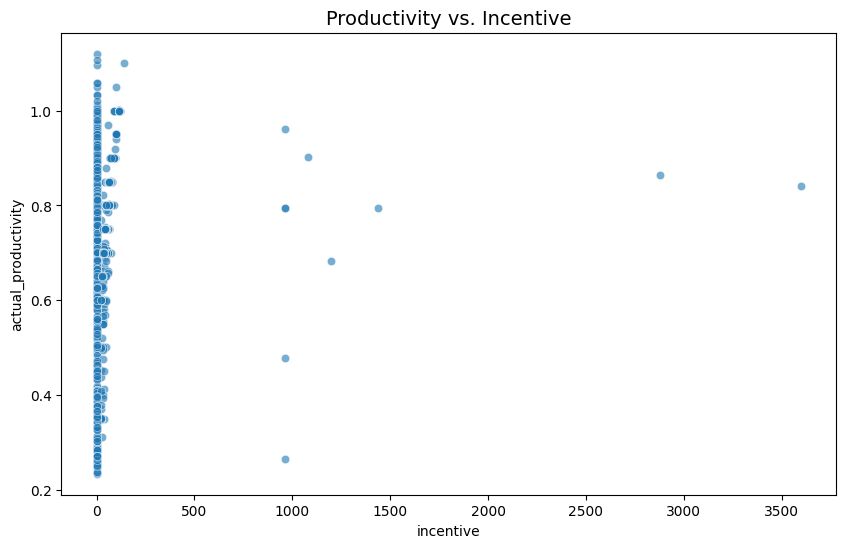

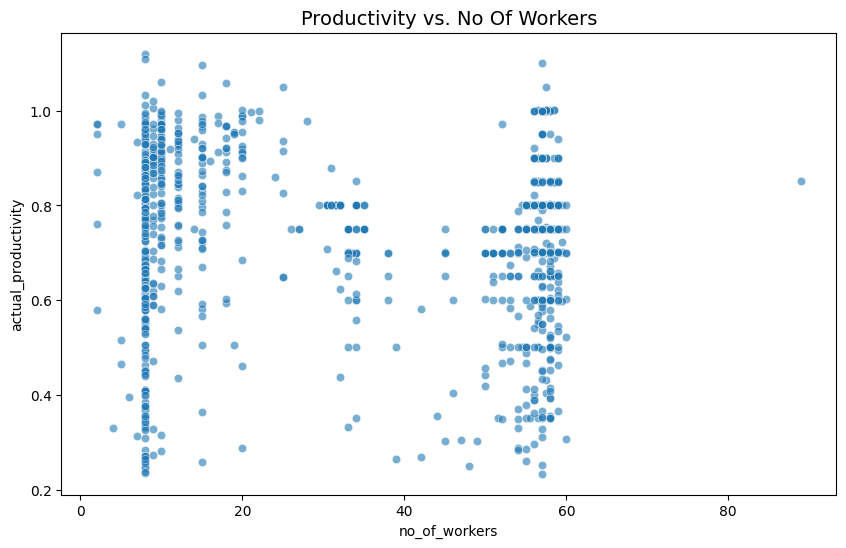

In [9]:
# Boxplots for key categorical features vs. Productivity
categorical_features = ['quarter', 'department', 'day']
for feature in categorical_features:
    if feature in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[feature], y=df['actual_productivity'])
        plt.title(f'Productivity Across Different {feature.title()}s', fontsize=14)
        plt.show()

# Scatterplots for key numerical features vs. Productivity
numerical_features_to_plot = ['targeted_productivity', 'over_time', 'incentive', 'no_of_workers']
for feature in numerical_features_to_plot:
    if feature in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df[feature], y=df['actual_productivity'], alpha=0.6)
        plt.title(f'Productivity vs. {feature.replace("_", " ").title()}', fontsize=14)
        plt.show()

In [10]:
df.isnull().sum()

team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
department_finishing       0
department_sweing          0
quarter_Quarter2           0
quarter_Quarter3           0
quarter_Quarter4           0
quarter_Quarter5           0
day_Saturday               0
day_Sunday                 0
day_Thursday               0
day_Tuesday                0
day_Wednesday              0
dtype: int64

In [11]:
# --- Safely handle the date column ---

# First, check if the 'date' column actually exists
if 'date' in df.columns:
    print("Processing 'date' column...")
    # Convert 'date' column to a datetime object
    df['date'] = pd.to_datetime(df['date'])

    # Extract features like day, month, and year
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    # Drop the original 'date' column as we've replaced it
    df = df.drop('date', axis=1)
else:
    print("'date' column has already been processed.")

'date' column has already been processed.


In [12]:
# Fill missing 'wip' values with the mean of the column
# inplace=True modifies the DataFrame directly
df['wip'] = df['wip'].fillna(df['wip'].mean())

# Confirm that there are no more missing values
print(df.isnull().sum())

team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
department_finishing     0
department_sweing        0
quarter_Quarter2         0
quarter_Quarter3         0
quarter_Quarter4         0
quarter_Quarter5         0
day_Saturday             0
day_Sunday               0
day_Thursday             0
day_Tuesday              0
day_Wednesday            0
dtype: int64


In [13]:
# This is the recommended way to fill missing values
df['wip'] = df['wip'].fillna(df['wip'].mean())

In [14]:
# See the new columns and confirm no missing values
df.info()

# View the first few rows of your fully numerical dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  department_finishing   1197 non-null   bool   
 12  department_sweing      1197 non-null   bool   
 13  quarter_Quarter2       1197 non-null   bool   
 14  quarter_Quarter3       1197 non-null   bool   
 15  quar

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_sweing,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0,...,True,False,False,False,False,False,False,True,False,False
1,1,0.75,3.94,1190.465991,960,0,0.0,0,0,8.0,...,False,False,False,False,False,False,False,True,False,False
2,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,...,True,False,False,False,False,False,False,True,False,False
3,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,...,True,False,False,False,False,False,False,True,False,False
4,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0,...,True,False,False,False,False,False,False,True,False,False


In [15]:
# The 'target' is what we want to predict
y = df['actual_productivity']

# The 'features' are all columns except the target
X = df.drop('actual_productivity', axis=1)

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into 80% for training and 20% for testing
# random_state=42 ensures you get the same split every time you run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (957, 21)
X_test shape: (240, 21)
y_train shape: (957,)
y_test shape: (240,)


In [18]:
# Check the data types of all columns in X_train
print(X_train.dtypes)

team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
department_finishing        bool
department_sweing           bool
quarter_Quarter2            bool
quarter_Quarter3            bool
quarter_Quarter4            bool
quarter_Quarter5            bool
day_Saturday                bool
day_Sunday                  bool
day_Thursday                bool
day_Tuesday                 bool
day_Wednesday               bool
dtype: object


In [19]:
from sklearn.linear_model import LinearRegression

# Create an instance of the model
lr_model = LinearRegression()

# Train the model on your training data
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# This will print the names of any columns that still contain text
print(df.select_dtypes(include=['object']).columns)


Index([], dtype='object')


In [21]:
# --- This is the correct code for converting text columns ---

# List of all columns that might contain text
categorical_cols = ['department', 'daytype', 'quarter', 'day']

# Find which of those columns still exist
cols_to_convert = [col for col in categorical_cols if col in df.columns]

# Only convert the columns that are found
if cols_to_convert:
    print(f"Converting columns: {cols_to_convert}")
    df = pd.get_dummies(df, columns=cols_to_convert, drop_first=True)
else:
    print("Categorical columns were already converted.")

Categorical columns were already converted.


In [22]:
print(df.columns)

Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity', 'department_finishing ', 'department_sweing',
       'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4',
       'quarter_Quarter5', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday'],
      dtype='object')


In [23]:
y = df['actual_productivity']
X = df.drop('actual_productivity', axis=1)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.linear_model import LinearRegression

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


In [26]:
# --- 1. Hyperparameter Tuning for Ridge Regression ---

print("Tuning hyperparameters for Ridge Regression...")

# Define the model
ridge = Ridge()

# Define the grid of parameters to search
# 'alpha' controls the amount of regularization.
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Set up the grid search
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, 
                                 cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search_ridge.fit(X_train, y_train)

# Print the best parameters found
print(f"Best parameters for Ridge Regression: {grid_search_ridge.best_params_}")

# Now, train your final model using these best parameters
final_ridge_model = Ridge(**grid_search_ridge.best_params_)
final_ridge_model.fit(X_train, y_train)

# You can now evaluate this final_ridge_model on your X_test data

Tuning hyperparameters for Ridge Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Ridge Regression: {'alpha': 0.1}


,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [27]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the test data
predictions = lr_model.predict(X_test)

# Check the performance
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 0.10845261337978306
R-squared: 0.16816825663051782


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# --- 2. Hyperparameter Tuning for Random Forest ---

print("\nTuning hyperparameters for Random Forest...")

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the grid of parameters to search
# This is a smaller grid for faster results. You can expand it.
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up the grid search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                              cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters found
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

# Now, train your final model using these best parameters
# This is the model you will save as 'model_rf.pkl'
final_rf_model = RandomForestRegressor(**grid_search_rf.best_params_, random_state=42)
final_rf_model.fit(X_train, y_train)


Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


,n_estimators,200
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
# Make predictions with the Random Forest model
rf_predictions = rf_model.predict(X_test)

# Check the performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("--- Random Forest Performance ---")
print(f"Mean Absolute Error: {rf_mae}")
print(f"R-squared: {rf_r2}")

--- Random Forest Performance ---
Mean Absolute Error: 0.07253253419666664
R-squared: 0.4734680711857362


In [31]:
from xgboost import XGBRegressor

# Create and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
# --- 3. Hyperparameter Tuning for XGBoost ---

print("\nTuning hyperparameters for XGBoost...")

# Define the model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the distribution of parameters to search
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.7, 0.8, 1.0]
}

# Set up the randomized search
# n_iter=25 means it will try 25 different combinations of parameters
random_search_xgb = RandomizedSearchCV(estimator=xgbr, param_distributions=param_dist_xgb,
                                       n_iter=25, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', 
                                       verbose=2, random_state=42)

# Fit the randomized search to the data
random_search_xgb.fit(X_train, y_train)

# Print the best parameters found
print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")

# Now, train your final model using these best parameters
final_xgb_model = xgb.XGBRegressor(**random_search_xgb.best_params_, random_state=42)
final_xgb_model.fit(X_train, y_train)


Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
# Make predictions with the XGBoost model
xgb_predictions = xgb_model.predict(X_test)

# Check the performance
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("--- XGBoost Performance ---")
print(f"Mean Absolute Error: {xgb_mae}")
print(f"R-squared: {xgb_r2}")

--- XGBoost Performance ---
Mean Absolute Error: 0.0795788861006537
R-squared: 0.32369494499785134


In [34]:
import pickle

# The 'rf_model' is the variable holding your trained Random Forest
# 'wb' means 'write binary' mode
with open('model_rf.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Random Forest model saved successfully as model_rf.pkl")

Random Forest model saved successfully as model_rf.pkl


In [35]:
print(X_train.columns.tolist())

['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'department_finishing ', 'department_sweing', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']


In [36]:
print(X_train.columns.tolist())

['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'department_finishing ', 'department_sweing', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']


In [37]:
import pickle

# Save the list of column names to a file
with open('model_columns.pkl', 'wb') as file:
    pickle.dump(X_train.columns, file)

print("Model columns saved successfully to model_columns.pkl!")


Model columns saved successfully to model_columns.pkl!
